In [1]:
import pandas as pd
import numpy as np
import pickle
import os


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

np.set_printoptions(suppress=True)

os.chdir("../")


In [2]:
# parameters
global_capacity_percent = 1.0  # 100% capacity
global_columns = ['id', 'cpu', 'memory', 'storage', 'bandwidth']

synthetic2 = False

if synthetic2:
    global_topology = 'synthetic'
    global_path = 'melbourne2/'

    import get_data as gd  # type: ignore

    sequence = ['App0', 'App1', 'App2', 'App3', 'App4', 'App5', 'App6', 'App7', 'App8', 'App9', 
                'App10', 'App11', 'App12', 'App13', 'App14', 'App15', 'App16', 'App17', 'App18', 'App19']

else:
    global_topology = 'germany'
    global_path = 'orign/'

    import get_data as gd  # type: ignore

    sequence = ['App11', 'App4', 'App6', 'App19', 'App12', 'App15', 'App16', 'App18', 'App7', 'App8', 
                'App13', 'App9', 'App10', 'App17', 'App2', 'App0', 'App3', 'App5', 'App1', 'App14']




In [3]:
def get_data_nodes(topology, capacity_percent, columns):
    """
    Fetches topology nodes and edges, and returns the graph structure.
    """
    df_nodes, df_edges = gd.get_topology(topology, capacity_percent=capacity_percent)
    graph = gd.create_graph_topology(df_nodes, df_edges)
    return df_nodes[columns], df_edges, graph

def get_data_application(app_name, app_path, columns):
    """
    Fetches the service and choreography data for a given application.
    """
    df_services, df_choreog = gd.get_application(app_name, app_path)
    services_df = df_services[columns]
    services_df.loc[:, 'id'] = range(0, len(services_df))
    return services_df, df_choreog

nodes_dataframe, edge_dataframe, graph_topology = get_data_nodes(global_topology, global_capacity_percent, global_columns)
nodes = nodes_dataframe.to_numpy()
hops = gd.floyd_warshall(graph_topology, weight='hops')


app_services = []
dict_apps = dict()

for i in range(20):
    services_data, choreography_data = get_data_application('App'+str(i), global_path, global_columns)
    app_services.append(len(services_data))
    dict_apps['App'+str(i)] = [services_data.to_numpy()[:,0].astype('int')]


display(len(nodes_dataframe))

50

In [4]:
# read pickle file and return a dictionary
def read_pickle_file(file_name):
    df = pd.read_pickle(file_name)
    return df

def get_dataframe(fuction, dict_lines):

    df = pd.DataFrame(columns=[])
    
    for key, values in dict_lines.items():
        df[key], keys = fuction(values)
    
    # insert keys to df as first column
    df.insert(0, 'app', keys)
    return df

def count_nodes(lines):
    nodes = []
    for key, values in lines.items():
        nodes_for_app = []
        for v in values:
            nodes_for_app.append(v[0])
        # elimiando nós repetidos da lista
        nodes_for_app = list(set(nodes_for_app))
        nodes.append(len(nodes_for_app))

    keys = list(lines.keys())
    return nodes, keys

# Calculado a utilização de CPU, memória e armazenamento para cada aplicação
def get_nodes_utilization(lines):

    services_placed = []
    nodes_utilization = []

    # nodes to list
    nodes_list = list(nodes)

    for key, values in lines.items():
        # services_placed = dict_apps[key]
        services_placed, c = get_data_application(key, global_path, global_columns)

        nodes_allocated = []
        nodes_allocated.append([v[0] for v in values])
        all_service, all_node = 0, 0
        
        nodes_allocated_data = []
        for nds in nodes_allocated:
            for n in list(set(nds)):
                nodes_allocated_data.append(nodes_list[n])

        all_service = np.sum(services_placed, axis=0)
        all_node = np.sum(nodes_allocated_data, axis=0)

        nodes_utilization.append(np.sum((all_service[1:])) / np.sum(all_node[1:]))

    keys = list(lines.keys())

    return nodes_utilization, keys


def count_hops(lines):
    hops_by_app = []
    for key, values in lines.items():
        nodes_allocated = []
        hops_counter = 0
        for v in values:
            nodes_allocated.append(v[0])
        
        for n in range(len(nodes_allocated)-1):
            source = [nodes_allocated[n]][0]
            target = [nodes_allocated[n+1]][0]
            hops_counter += hops[source][target]
        hops_by_app.append(hops_counter)
    keys = list(lines.keys())
    
    return hops_by_app, keys

In [5]:
def plot_grouped_bar_chart(dataframe, title, xlable, ylabel, dict_apps, file_name):

    plt.style.use('seaborn-v0_8-whitegrid')

    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    
    # Extracting labels and data from the dataframe
    labels = dataframe.iloc[:, 0].copy()
    data = dataframe.iloc[:, 1:]

    for i, l in enumerate(labels):
        labels[i] = str(len(dict_apps[l][0]))

    # Setting the positions and width for the bars
    bar_width = 0.35
    positions = np.arange(len(labels))

    colors = ['#DC143C', '#4169E1', '#008B8B', '#FFFF00', '#FFA500']

    # Plotting each set of bars
    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(12,7))
    for i, col in enumerate(data.columns):
        ax.bar(positions + i * bar_width, data[col], bar_width, label=col, color=colors[i])


    # Adding labels, title, and legend
    ax.set_xlabel(xlable, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_title(title, fontsize = 20)
    ax.set_xticks(positions + bar_width * (len(data.columns) - 1) / 2)
    ax.set_xticklabels(labels)
    
    ax.legend()

    # Assuming your dataframe is named 'df'
    matrix = dataframe.iloc[:, 1:].values

    # Get the minimum and maximum values
    # min_value = np.min(matrix)
    max_value = np.max(matrix)
    
    # ax.set_ylim(0, dataframe.iloc[:,1].max()+dataframe.iloc[:,1].min())
    ax.set_ylim(0, max_value*1.2)

    # Show the plot
    ax.legend(ncol=3, fontsize=16)
    # plt.xticks(rotation=90)
    # plt.show()
    plt.savefig('plots/'+file_name+'.svg', format='svg')

In [6]:
def plot_grouped_bar_chart2(dataframe, title, xlabel, ylabel, dict_apps, file_name):
    """
    Plota um gráfico de barras agrupadas.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({'xtick.labelsize': 10, 'ytick.labelsize': 10})

    labels = dataframe.iloc[:, 0].copy()
    data = dataframe.iloc[:, 1:]

    for i, l in enumerate(labels):
        labels[i] = str(len(dict_apps[l][0]))

    bar_width = 0.35
    positions = np.arange(len(labels))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    fig, ax = plt.subplots(figsize=(12, 7))
    for i, col in enumerate(data.columns):
        ax.bar(positions + i * bar_width, data[col], bar_width, label=col, color=colors[i])

    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    # ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(positions + bar_width * (len(data.columns) - 1) / 2)

    # Inserir abaixo do número de serviços de cada aplicação o nome da aplicação
    for i, l in enumerate(labels):
        labels[i] = l + '\n' + sequence[i]
        
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(ncol=3, fontsize=12)

    ax.set_ylim(0, data.values.max() * 1.2)
    plt.tight_layout()
    plt.grid(False)
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.savefig(f'graphs/plots/{file_name}.svg', format='svg')



In [7]:
dict_m1_h1 = dict()
dict_m2_h2 = dict()
dict_m3_h3 = dict()

english = False
if english:
    heu = 'Heuristic'
    mod = 'Model'
else:
    heu = 'Heurística'
    mod = 'Modelo'

if synthetic2:
    print('synthetic')
    dict_m1_h1[heu+' H-1'] = read_pickle_file('results/placements/h1_min_nodes_alloc_synthetic_place.pkl')
    dict_m1_h1[mod+' M-1'] = read_pickle_file('results/placements/m1_min_nodes_alloc_synthetic_place.pkl')

    df_m1_h1 = get_dataframe(count_nodes, dict_m1_h1)

    dict_m2_h2[heu+' H-2'] = read_pickle_file('results/placements/h2_min_residual_synthetic_place.pkl')
    dict_m2_h2[mod+' M-2'] = read_pickle_file('results/placements/m2_min_residual_synthetic_place.pkl')

    df_m2_h2 = get_dataframe(get_nodes_utilization, dict_m2_h2)

    dict_m3_h3[heu+' H-3'] = read_pickle_file('results/placements/h3_min_hops_synthetic_place.pkl')
    dict_m3_h3[mod+' M-3'] = read_pickle_file('results/placements/m3_min_hops_synthetic_30min_place.pkl')

    df_m3_h3 = get_dataframe(count_hops, dict_m3_h3)

else:
    print(global_topology)
    print('results/placements/h1_min_nodes_alloc_'+global_topology+'_new_place.pkl')
    dict_m1_h1[heu+' H-1'] = read_pickle_file('results/placements/h1_min_nodes_alloc_'+global_topology+'_place.pkl')
    dict_m1_h1[mod+' M-1'] = read_pickle_file('results/placements/m1_min_nodes_alloc_'+global_topology+'_place.pkl')

    df_m1_h1 = get_dataframe(count_nodes, dict_m1_h1)
    df_m1_h1 = df_m1_h1.set_index('app').loc[sequence].reset_index()

    dict_m2_h2[heu+' H-2'] = read_pickle_file('results/placements/h2_min_residual_'+global_topology+'_place.pkl')
    dict_m2_h2[mod+' M-2'] = read_pickle_file('results/placements/m2_min_residual_'+global_topology+'_place.pkl')

    df_m2_h2 = get_dataframe(get_nodes_utilization, dict_m2_h2)
    df_m2_h2 = df_m2_h2.set_index('app').loc[sequence].reset_index()

    dict_m3_h3[heu+' H-3'] = read_pickle_file('results/placements/h3_min_hops_'+global_topology+'_place.pkl')
    dict_m3_h3[mod+' M-3'] = read_pickle_file('results/placements/m3_min_hops_'+global_topology+'_30min_place.pkl')

    df_m3_h3 = get_dataframe(count_hops, dict_m3_h3)
    df_m3_h3 = df_m3_h3.set_index('app').loc[sequence].reset_index()


    



germany
results/placements/h1_min_nodes_alloc_germany_new_place.pkl


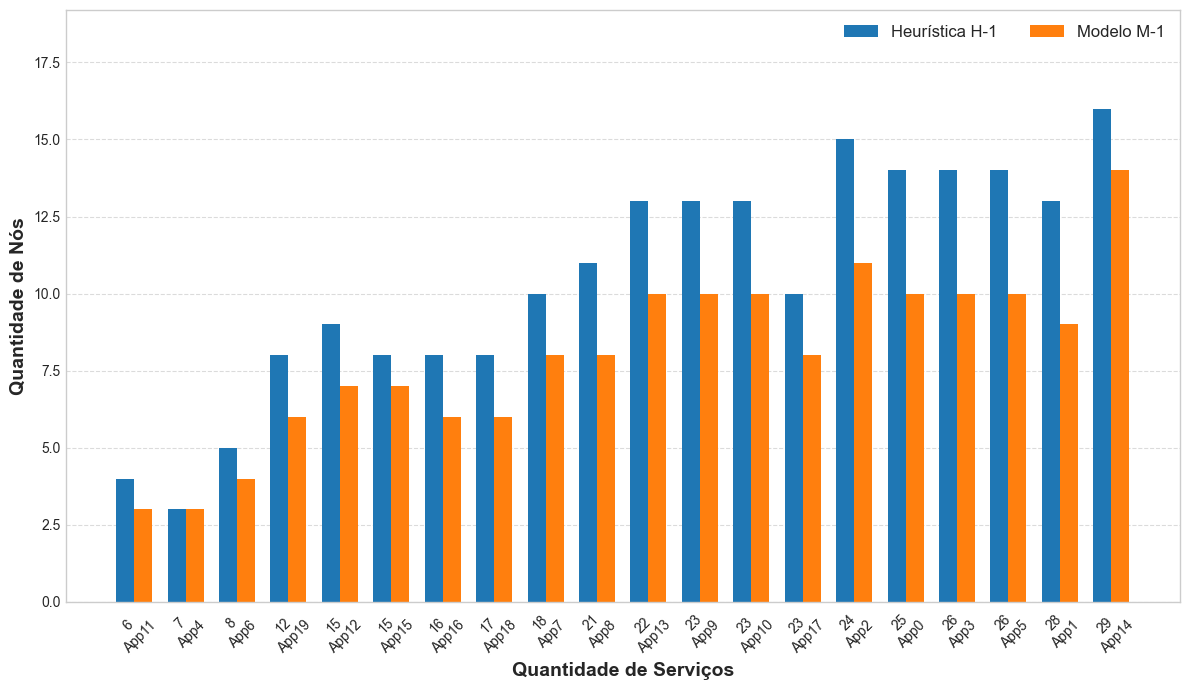

In [8]:
# Plotando resultados de minimização de nós 

plot_grouped_bar_chart2(df_m1_h1, global_topology[0].upper() + global_topology[1:]+' Topology', 'Quantidade de Serviços', 'Quantidade de Nós', dict_apps, 'm1_h1_min_nodes_'+global_topology)
# plot_grouped_bar_chart2(df_m1_h1, global_topology[0].upper() + global_topology[1:]+' Topology', 'Number of Services', 'Number of Nodes', dict_apps, 'm1_h1_min_nodes_'+global_topology)

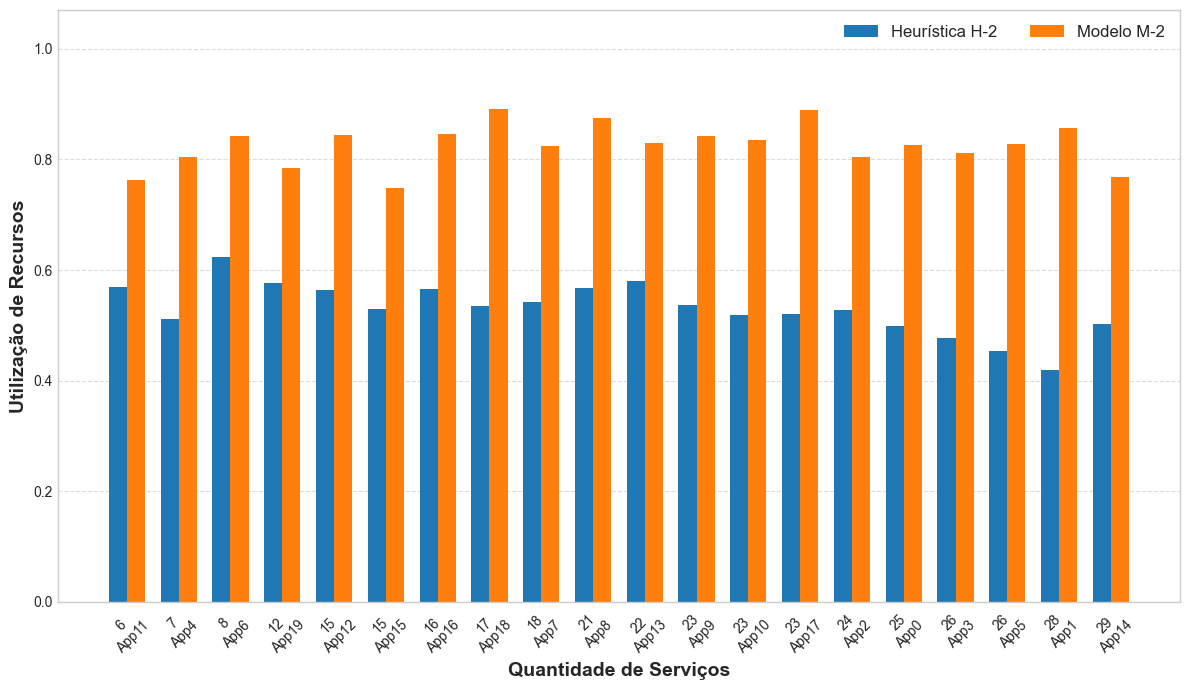

In [9]:
plot_grouped_bar_chart2(df_m2_h2, global_topology[0].upper() + global_topology[1:]+' Topology', 'Quantidade de Serviços', 'Utilização de Recursos', dict_apps, 'm2_h2_min_residual_'+global_topology)
# plot_grouped_bar_chart2(df_m2_h2, global_topology[0].upper() + global_topology[1:]+' Topology', 'Number of Nodes', 'Resource Utilization', dict_apps, 'm2_h2_min_residual_'+global_topology)


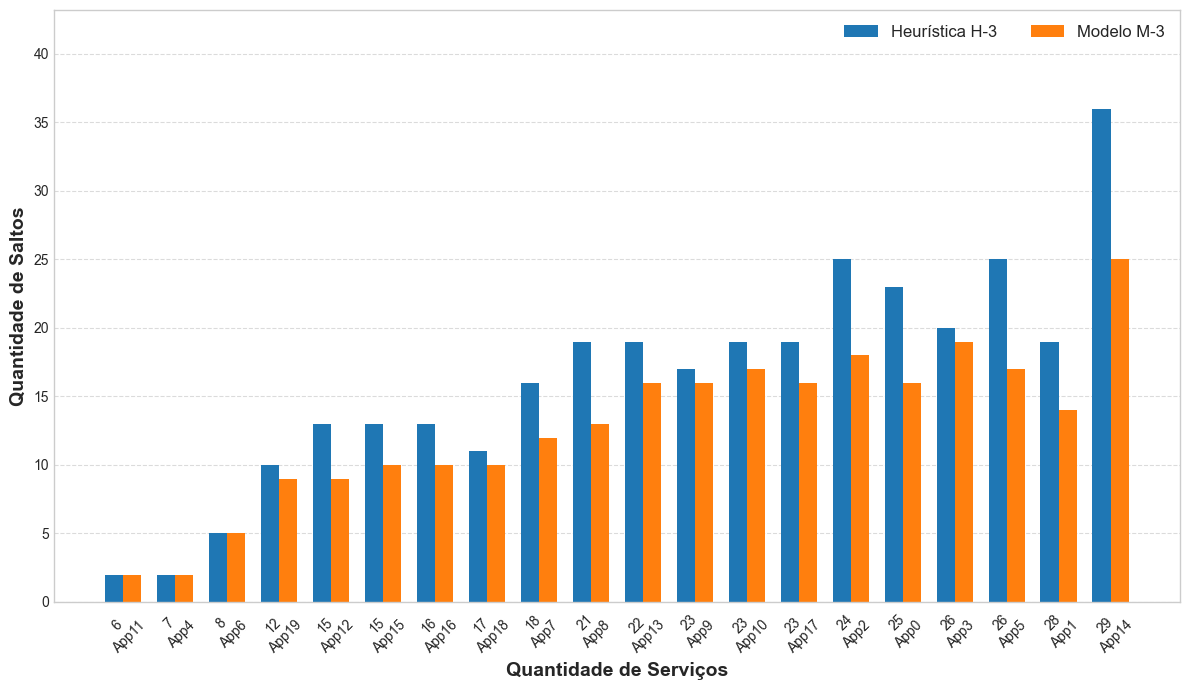

In [10]:
plot_grouped_bar_chart2(df_m3_h3, global_topology[0].upper() + global_topology[1:]+' Topology', 'Quantidade de Serviços', 'Quantidade de Saltos', dict_apps, 'm3_h3_min_hops_'+global_topology)
# plot_grouped_bar_chart2(df_m3_h3, global_topology[0].upper() + global_topology[1:]+' Topology', 'Number of Services', 'Number of Hops', dict_apps, 'm3_h3_min_hops_'+global_topology)


In [11]:
print(df_m1_h1.describe())

       Heurística H-1  Modelo M-1
count       20.000000   20.000000
mean        10.450000    8.000000
std          3.762348    2.809757
min          3.000000    3.000000
25%          8.000000    6.000000
50%         10.500000    8.000000
75%         13.250000   10.000000
max         16.000000   14.000000


In [12]:
print(df_m2_h2.describe())

       Heurística H-2  Modelo M-2
count       20.000000   20.000000
mean         0.530988    0.825837
std          0.047056    0.039307
min          0.419942    0.749102
25%          0.508665    0.804732
50%          0.531741    0.829186
75%          0.566528    0.843933
max          0.623485    0.891690


In [13]:
print(df_m3_h3.describe())

       Heurística H-3  Modelo M-3
count        20.00000   20.000000
mean         16.30000   12.800000
std           8.18278    5.800181
min           2.00000    2.000000
25%          12.50000    9.750000
50%          18.00000   13.500000
75%          19.25000   16.250000
max          36.00000   25.000000
